# American Basket Option Pricing: GBM vs Heston

Compare American basket option pricing using correlated GBM and Heston models with real market data.

## Features:
- **Market Data**: Calibrated Heston parameters and correlation matrix
- **Longstaff-Schwartz**: American option pricing with early exercise
- **Delta Analysis**: Individual asset sensitivities grouped by characteristics

## 1. Import Libraries and Load Market Data

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal
import warnings
warnings.filterwarnings('ignore')

# Import directly from the module - reload if you've made changes
import importlib
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('')))

import longstaff_schwartz
importlib.reload(longstaff_schwartz)

# Import specific classes from longstaff_schwartz module
from longstaff_schwartz import (
    CorrelatedGBM,
    CorrelatedHeston,
    PolynomialBasis,
    LSMOptionPricer
)

# Configure matplotlib for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 0.8

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Market Data

Load calibrated Heston parameters and correlation matrix from market option data.

In [2]:
# Load Heston parameters from CSV
heston_params_df = pd.read_csv('../heston_parameters.csv')
print("Loaded Heston parameters for", len(heston_params_df), "assets:")
print(heston_params_df[['Ticker', 'Spot_Price', 'v0', 'theta', 'kappa', 'sigma', 'rho']].head())

# Load correlation matrix
corr_matrix_df = pd.read_csv('../heston_correlation_matrix.csv', index_col=0)
tickers = corr_matrix_df.columns.tolist()
correlation_matrix = corr_matrix_df.values

print(f"\nLoaded correlation matrix for {len(tickers)} assets")
print("Tickers:", tickers[:10], "...")  # Show first 10

# Verify that the tickers match
heston_tickers = heston_params_df['Ticker'].tolist()
print(f"\nParameter tickers: {len(heston_tickers)}")
print(f"Correlation tickers: {len(tickers)}")
print(f"Tickers match: {heston_tickers == tickers}")

Loaded Heston parameters for 30 assets:
  Ticker  Spot_Price        v0     theta      kappa     sigma       rho
0   AMZN  225.690002  0.142785  0.022527   5.257682  0.679058 -0.730609
1  GOOGL  181.559998  0.189112  0.051514   7.102221  1.833685 -0.198440
2   TSLA  316.899994  0.425352  0.249332  14.888313  3.981922 -0.052605
3   NVDA  164.070007  0.085689  0.209709  11.013072  2.170797 -0.680514
4   AAPL  208.619995  0.097417  0.019915   2.556080  0.790582 -0.595051

Loaded correlation matrix for 30 assets
Tickers: ['AMZN', 'GOOGL', 'TSLA', 'NVDA', 'AAPL', 'MSFT', 'NFLX', 'META', 'CRM', 'ORCL'] ...

Parameter tickers: 30
Correlation tickers: 30
Tickers match: True


## 3. Extract Model Parameters

Extract parameters for both GBM and Heston models.

In [ ]:
# Extract parameters for simulation
n_assets = len(heston_params_df)
print(f"Using {n_assets} assets for basket option pricing")

# Stock prices and basic parameters
S0 = heston_params_df['Spot_Price'].values
print(f"Initial stock prices range: ${S0.min():.2f} to ${S0.max():.2f}")

# Heston model parameters
v0 = heston_params_df['v0'].values          # Initial variance
theta = heston_params_df['theta'].values    # Long-term variance  
kappa = heston_params_df['kappa'].values    # Mean reversion speed
sigma_v = heston_params_df['sigma'].values  # Volatility of volatility
rho_sv = heston_params_df['rho'].values     # Stock-variance correlation

# For GBM, we'll use the square root of initial variance as volatility
sigma_gbm = np.sqrt(v0)
print(f"GBM volatilities range: {sigma_gbm.min():.3f} to {sigma_gbm.max():.3f}")

# Build covariance matrix for GBM using correlation matrix and volatilities
cov_matrix = np.zeros((n_assets, n_assets))
for i in range(n_assets):
    for j in range(n_assets):
        cov_matrix[i, j] = correlation_matrix[i, j] * sigma_gbm[i] * sigma_gbm[j]

print(f"Covariance matrix shape: {cov_matrix.shape}")
print(f"Average correlation: {np.mean(correlation_matrix[np.triu_indices(n_assets, k=1)]):.3f}")

# Market and option parameters
r = 0.05  # Risk-free rate (3%)
T = 3/12  # 3 months to expiration
step = 60  # Daily steps (approximately)
N = 100000   # Number of Monte Carlo paths

# Basket parameters - use inverse price weights (more logical for basket options)
# Equal weights would give higher-priced stocks disproportionate influence
inverse_weights = 1 / S0
weights = inverse_weights / np.sum(inverse_weights)  # Normalize to sum to 1

print(f"Using inverse price weights:")
print(f"  Highest weight: {np.max(weights):.4f} (lowest price: ${S0[np.argmax(weights)]:.2f})")
print(f"  Lowest weight: {np.min(weights):.4f} (highest price: ${S0[np.argmin(weights)]:.2f})")

# Strike price - use weighted average with inverse price weights
K = np.average(S0, weights=weights)  # Weighted average as ATM strike
print(f"Strike price (ATM): ${K:.2f}")
print(f"Risk-free rate: {r*100:.1f}%")
print(f"Time to expiration: {T*12:.1f} months")
print(f"Number of time steps: {step}")
print(f"Number of MC paths: {N:,}")

Using 30 assets for basket option pricing
Initial stock prices range: $25.35 to $1261.95
GBM volatilities range: 0.100 to 0.652
Covariance matrix shape: (30, 30)
Average correlation: 0.488
Strike price (ATM): $275.26
Risk-free rate: 5.0%
Time to expiration: 3.0 months
Number of time steps: 60
Number of MC paths: 100,000


## 4. Market Structure

Examine correlation structure and parameter distributions.

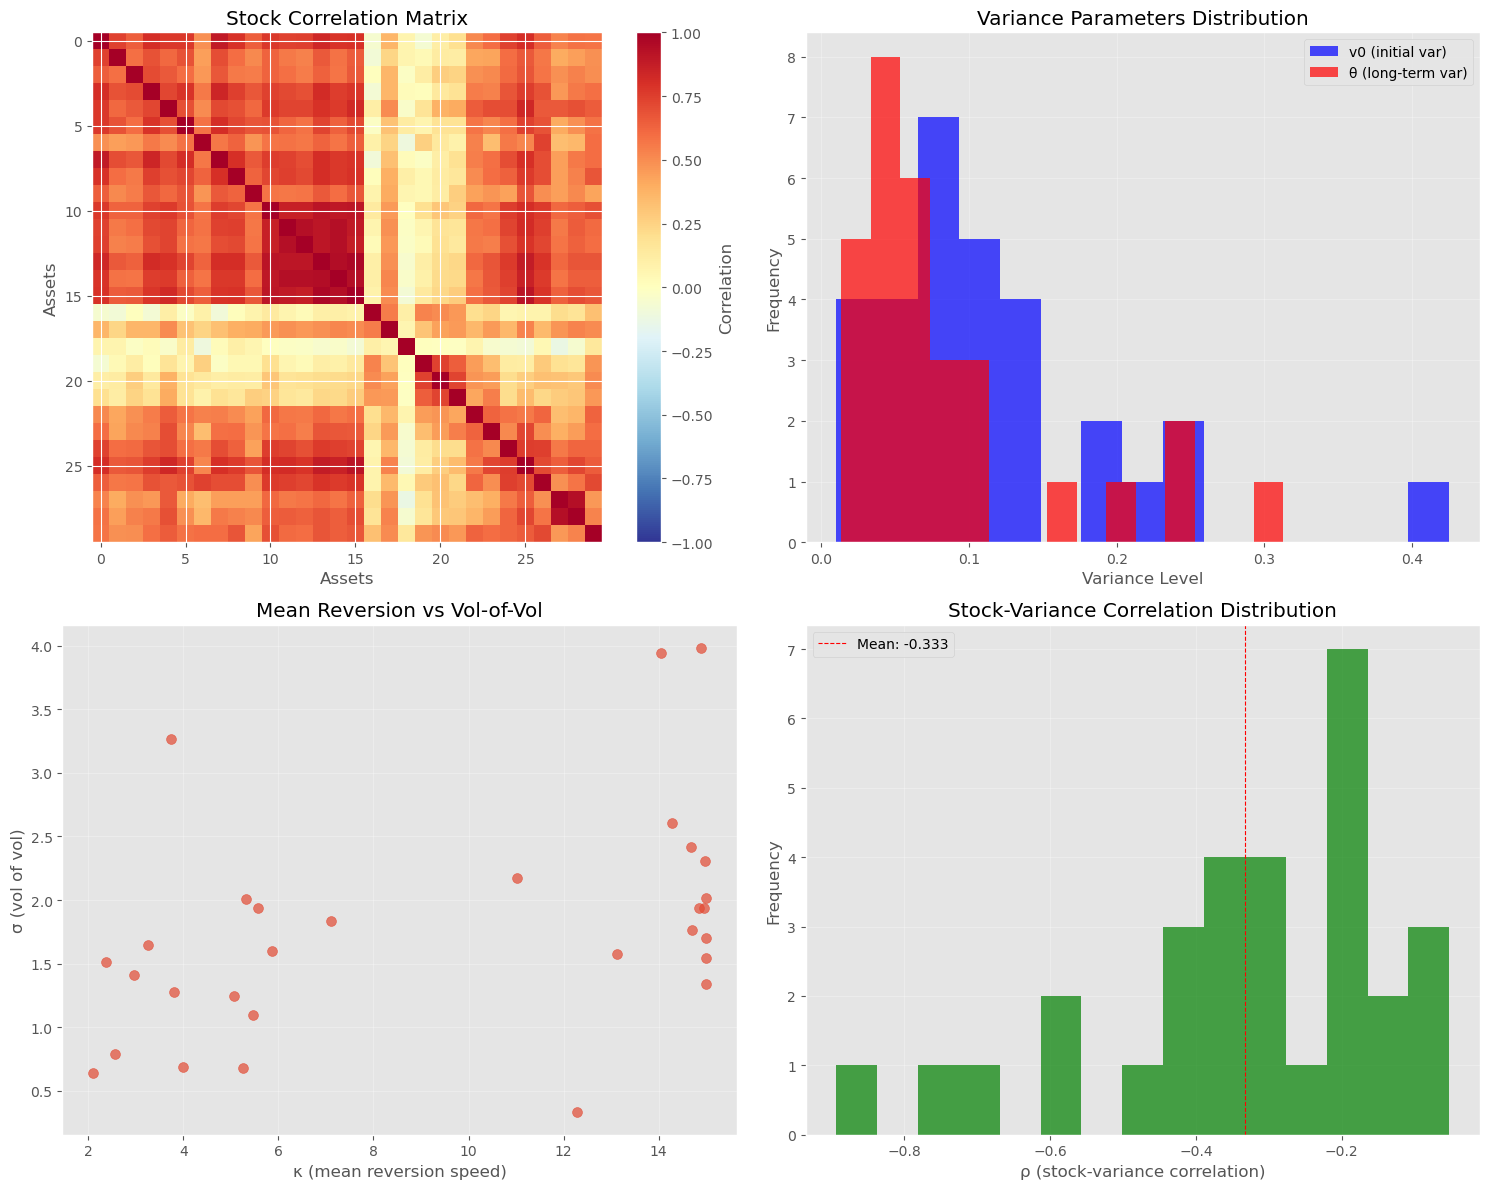

=== MARKET PARAMETERS ===
Initial variance (v0):     0.1143 ± 0.0855
Long-term variance (θ):    0.0867 ± 0.0740
Mean reversion (κ):        9.27 ± 5.15
Vol of vol (σ):            1.77 ± 0.85
Stock-vol correlation (ρ): -0.333 ± 0.200
Average stock correlation:  0.488


In [4]:
# Create visualizations of market structure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Correlation heatmap
im1 = axes[0,0].imshow(correlation_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
axes[0,0].set_title('Stock Correlation Matrix')
axes[0,0].set_xlabel('Assets')
axes[0,0].set_ylabel('Assets')
plt.colorbar(im1, ax=axes[0,0], label='Correlation')

# 2. Heston parameter distributions
axes[0,1].hist(v0, bins=15, alpha=0.7, label='v0 (initial var)', color='blue')
axes[0,1].hist(theta, bins=15, alpha=0.7, label='θ (long-term var)', color='red')
axes[0,1].set_title('Variance Parameters Distribution')
axes[0,1].set_xlabel('Variance Level')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Volatility parameters
axes[1,0].scatter(kappa, sigma_v, alpha=0.7, s=50)
axes[1,0].set_xlabel('κ (mean reversion speed)')
axes[1,0].set_ylabel('σ (vol of vol)')
axes[1,0].set_title('Mean Reversion vs Vol-of-Vol')
axes[1,0].grid(True, alpha=0.3)

# 4. Stock-variance correlation
axes[1,1].hist(rho_sv, bins=15, alpha=0.7, color='green')
axes[1,1].set_xlabel('ρ (stock-variance correlation)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Stock-Variance Correlation Distribution')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axvline(x=np.mean(rho_sv), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(rho_sv):.3f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== MARKET PARAMETERS ===")
print(f"Initial variance (v0):     {np.mean(v0):.4f} ± {np.std(v0):.4f}")
print(f"Long-term variance (θ):    {np.mean(theta):.4f} ± {np.std(theta):.4f}")
print(f"Mean reversion (κ):        {np.mean(kappa):.2f} ± {np.std(kappa):.2f}")
print(f"Vol of vol (σ):            {np.mean(sigma_v):.2f} ± {np.std(sigma_v):.2f}")
print(f"Stock-vol correlation (ρ): {np.mean(rho_sv):.3f} ± {np.std(rho_sv):.3f}")
print(f"Average stock correlation:  {np.mean(correlation_matrix[np.triu_indices(n_assets, k=1)]):.3f}")

## 5. GBM Simulation

Simulate correlated GBM model using market correlation structure.

GBM SIMULATION
Generating GBM paths...
Generated 100,000 paths with 61 time steps for 30 assets
Basket paths shape: (100000, 61)

GBM STATISTICS:
Initial basket price:     $275.26
Simulated final price:    $278.60 ± $36.59
Min/Max final prices:     $158.87 / $480.97
Generated 100,000 paths with 61 time steps for 30 assets
Basket paths shape: (100000, 61)

GBM STATISTICS:
Initial basket price:     $275.26
Simulated final price:    $278.60 ± $36.59
Min/Max final prices:     $158.87 / $480.97


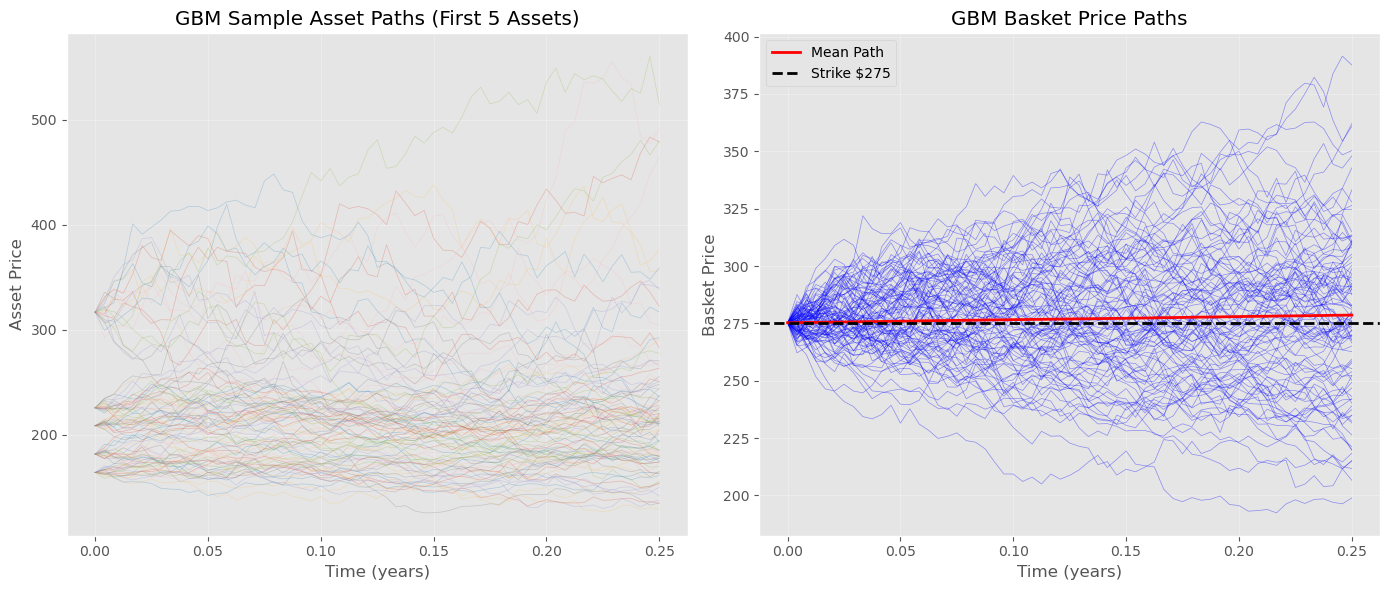

In [5]:
print("="*50)
print("GBM SIMULATION")
print("="*50)

# Create GBM simulator
gbm_sim = CorrelatedGBM(S0, r, cov_matrix, T, step, N, weights)

# Generate paths
print("Generating GBM paths...")
gbm_paths = gbm_sim.generate_paths()
gbm_basket_paths = gbm_sim.get_basket_paths()

print(f"Generated {N:,} paths with {step+1} time steps for {n_assets} assets")
print(f"Basket paths shape: {gbm_basket_paths.shape}")

# Calculate statistics
initial_basket = np.sum(S0 * weights)
final_basket_prices = gbm_basket_paths[:, -1]
theoretical_price = initial_basket * np.exp(r * T)

print(f"\nGBM STATISTICS:")
print(f"Initial basket price:     ${initial_basket:.2f}")
print(f"Simulated final price:    ${np.mean(final_basket_prices):.2f} ± ${np.std(final_basket_prices):.2f}")
print(f"Min/Max final prices:     ${np.min(final_basket_prices):.2f} / ${np.max(final_basket_prices):.2f}")

# Plot some sample paths
plt.figure(figsize=(14, 6))
time = np.linspace(0, T, step+1)

plt.subplot(1, 2, 1)
# Plot subset of individual asset paths for first 5 assets
for i in range(min(5, n_assets)):
    for j in range(min(20, N)):
        plt.plot(time, gbm_paths[j, :, i], alpha=0.3, linewidth=0.5)
plt.title('GBM Sample Asset Paths (First 5 Assets)')
plt.xlabel('Time (years)')
plt.ylabel('Asset Price')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot basket paths
for j in range(min(100, N)):
    plt.plot(time, gbm_basket_paths[j, :], alpha=0.4, linewidth=0.5, color='blue')
plt.plot(time, np.mean(gbm_basket_paths, axis=0), 'r-', linewidth=2, label='Mean Path')
plt.axhline(y=K, color='black', linestyle='--', linewidth=2, label=f'Strike ${K:.0f}')
plt.title('GBM Basket Price Paths')
plt.xlabel('Time (years)')
plt.ylabel('Basket Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Heston Simulation

Simulate Heston stochastic volatility model with market-calibrated parameters.

HESTON SIMULATION
Generating Heston paths...
Generated 100,000 paths with 61 time steps for 30 assets
Basket paths shape: (100000, 61)
Variance paths shape: (100000, 61, 30)

HESTON STATISTICS:
Initial basket price:     $275.26
Simulated final price:    $278.64 ± $29.89
Average final variance:   0.1041
Average initial variance: 0.1143
Generated 100,000 paths with 61 time steps for 30 assets
Basket paths shape: (100000, 61)
Variance paths shape: (100000, 61, 30)

HESTON STATISTICS:
Initial basket price:     $275.26
Simulated final price:    $278.64 ± $29.89
Average final variance:   0.1041
Average initial variance: 0.1143


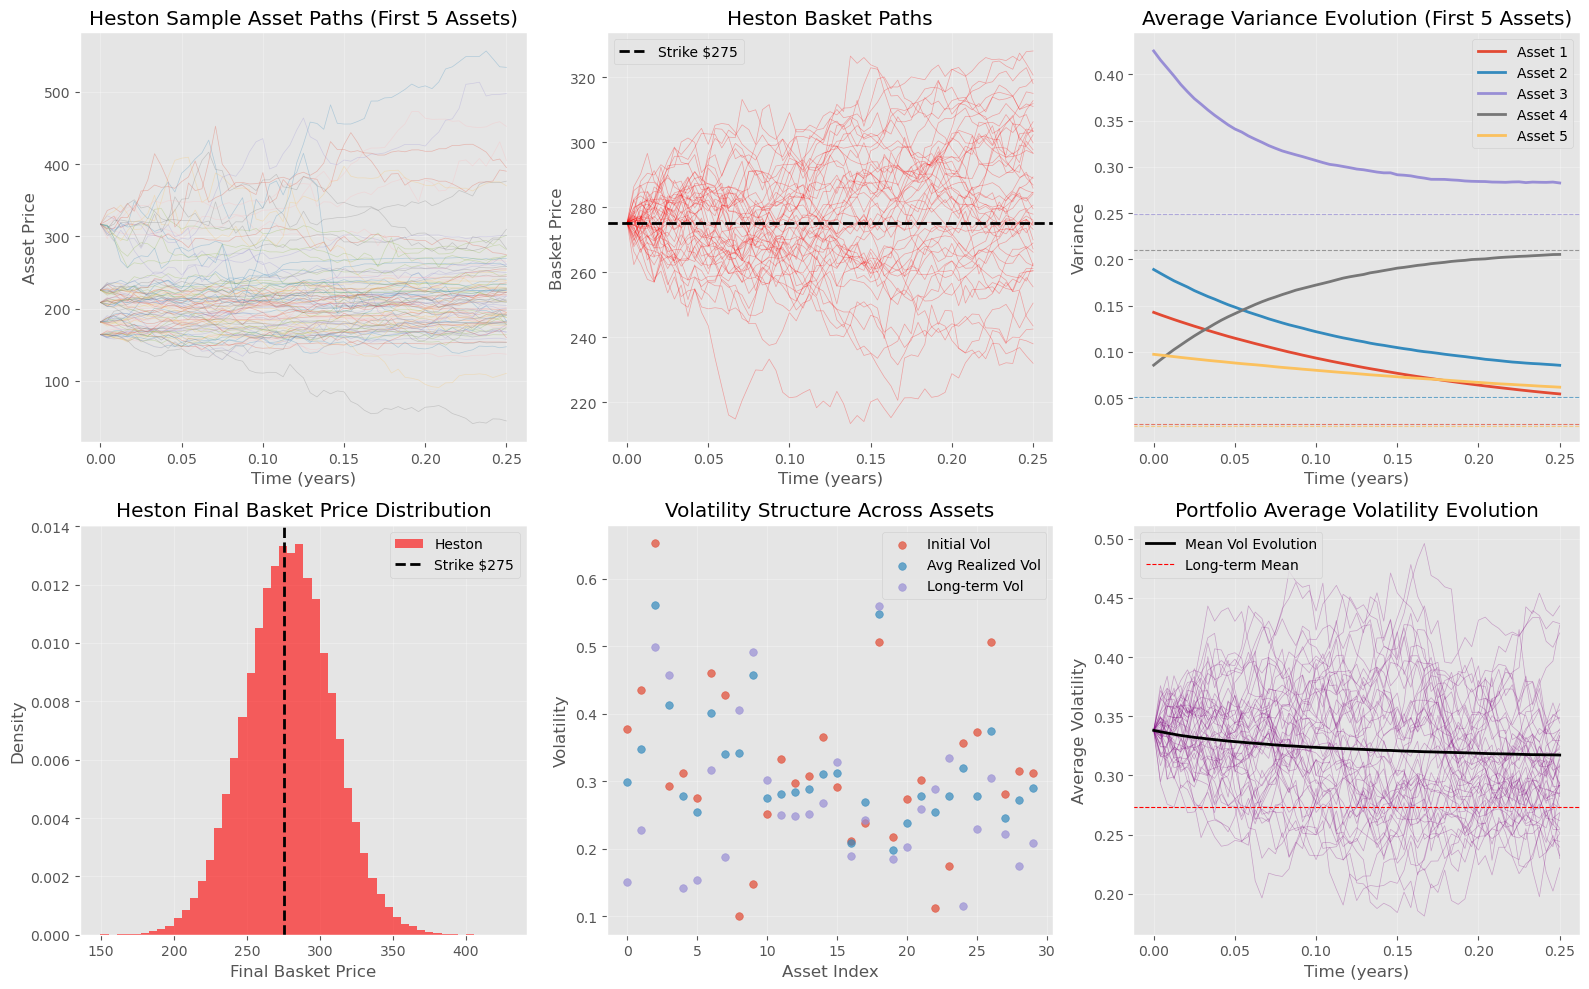


HESTON MODEL STATISTICS:
GBM final price:     $278.60 ± $36.59
Heston final price:  $278.64 ± $29.89
Heston volatility ratio: 0.817


In [6]:
print("="*50)
print("HESTON SIMULATION")
print("="*50)

# Create Heston simulator
heston_sim = CorrelatedHeston(
    S0=S0, 
    r=r, 
    v0=v0, 
    theta=theta, 
    kappa=kappa, 
    sigma=sigma_v, 
    rho_sv=rho_sv, 
    corr_matrix=correlation_matrix, 
    T=T, 
    step=step, 
    N=N, 
    weights=weights
)

# Generate paths
print("Generating Heston paths...")
heston_paths = heston_sim.generate_paths()
heston_basket_paths = heston_sim.get_basket_paths()
heston_variance_paths = heston_sim.get_variance_paths()

print(f"Generated {N:,} paths with {step+1} time steps for {n_assets} assets")
print(f"Basket paths shape: {heston_basket_paths.shape}")
print(f"Variance paths shape: {heston_variance_paths.shape}")

# Calculate statistics
final_basket_prices_heston = heston_basket_paths[:, -1]
final_variances = heston_variance_paths[:, -1, :]

print(f"\nHESTON STATISTICS:")
print(f"Initial basket price:     ${initial_basket:.2f}")
print(f"Simulated final price:    ${np.mean(final_basket_prices_heston):.2f} ± ${np.std(final_basket_prices_heston):.2f}")
print(f"Average final variance:   {np.mean(final_variances):.4f}")
print(f"Average initial variance: {np.mean(v0):.4f}")

# Plot Heston paths and variance evolution
plt.figure(figsize=(16, 10))

# Subplot 1: Individual asset paths (first 5 assets)
plt.subplot(2, 3, 1)
for i in range(min(5, n_assets)):
    for j in range(min(20, N)):
        plt.plot(time, heston_paths[j, :, i], alpha=0.3, linewidth=0.5)
plt.title('Heston Sample Asset Paths (First 5 Assets)')
plt.xlabel('Time (years)')
plt.ylabel('Asset Price')
plt.grid(True, alpha=0.3)

# Subplot 2: Basket paths 
plt.subplot(2, 3, 2)
for j in range(min(50, N)):
    plt.plot(time, heston_basket_paths[j, :], alpha=0.3, linewidth=0.5, color='red')
plt.axhline(y=K, color='black', linestyle='--', linewidth=2, label=f'Strike ${K:.0f}')
plt.title('Heston Basket Paths')
plt.xlabel('Time (years)')
plt.ylabel('Basket Price')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Variance evolution for first 5 assets
plt.subplot(2, 3, 3)
for i in range(min(5, n_assets)):
    mean_var_path = np.mean(heston_variance_paths[:, :, i], axis=0)
    plt.plot(time, mean_var_path, linewidth=2, label=f'Asset {i+1}')
    plt.axhline(y=theta[i], linestyle='--', alpha=0.7, color=plt.gca().lines[-1].get_color())
plt.title('Average Variance Evolution (First 5 Assets)')
plt.xlabel('Time (years)')
plt.ylabel('Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: Final price distribution
plt.subplot(2, 3, 4)
plt.hist(final_basket_prices_heston, bins=50, alpha=0.6, density=True, color='red', label='Heston')
plt.axvline(x=K, color='black', linestyle='--', linewidth=2, label=f'Strike ${K:.0f}')
plt.title('Heston Final Basket Price Distribution')
plt.xlabel('Final Basket Price')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 5: Volatility smile effect
plt.subplot(2, 3, 5)
# Show implied volatility from variance paths for each asset
avg_implied_vol = np.sqrt(np.mean(heston_variance_paths, axis=(0,1)))
initial_vol = np.sqrt(v0)
long_term_vol = np.sqrt(theta)

asset_indices = np.arange(n_assets)
plt.scatter(asset_indices, initial_vol, alpha=0.7, label='Initial Vol', s=30)
plt.scatter(asset_indices, avg_implied_vol, alpha=0.7, label='Avg Realized Vol', s=30)
plt.scatter(asset_indices, long_term_vol, alpha=0.7, label='Long-term Vol', s=30)
plt.title('Volatility Structure Across Assets')
plt.xlabel('Asset Index')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Path-wise volatility evolution
plt.subplot(2, 3, 6)
# Show average volatility across all assets over time
avg_vol_evolution = np.sqrt(np.mean(heston_variance_paths, axis=2))  # Average across assets
for j in range(min(50, N)):
    plt.plot(time, avg_vol_evolution[j, :], alpha=0.3, linewidth=0.5, color='purple')
mean_vol_evolution = np.mean(avg_vol_evolution, axis=0)
plt.plot(time, mean_vol_evolution, 'k-', linewidth=2, label='Mean Vol Evolution')
plt.axhline(y=np.mean(np.sqrt(theta)), linestyle='--', color='red', label='Long-term Mean')
plt.title('Portfolio Average Volatility Evolution')
plt.xlabel('Time (years)')
plt.ylabel('Average Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nHESTON MODEL STATISTICS:")
print(f"GBM final price:     ${np.mean(final_basket_prices):.2f} ± ${np.std(final_basket_prices):.2f}")
print(f"Heston final price:  ${np.mean(final_basket_prices_heston):.2f} ± ${np.std(final_basket_prices_heston):.2f}")
print(f"Heston volatility ratio: {np.std(final_basket_prices_heston) / np.std(final_basket_prices):.3f}")

## 7. GBM Option Pricing

Price American basket put options using GBM model.

GBM OPTION PRICING
Pricing American basket put options with strike K=$275.26

--- GBM OPTION PRICING ---


American put price (GBM):      $12.9492
European put price (GBM):      $12.8323
Early exercise premium (GBM):  $0.1169
In-the-money probability at expiration (GBM): 0.493


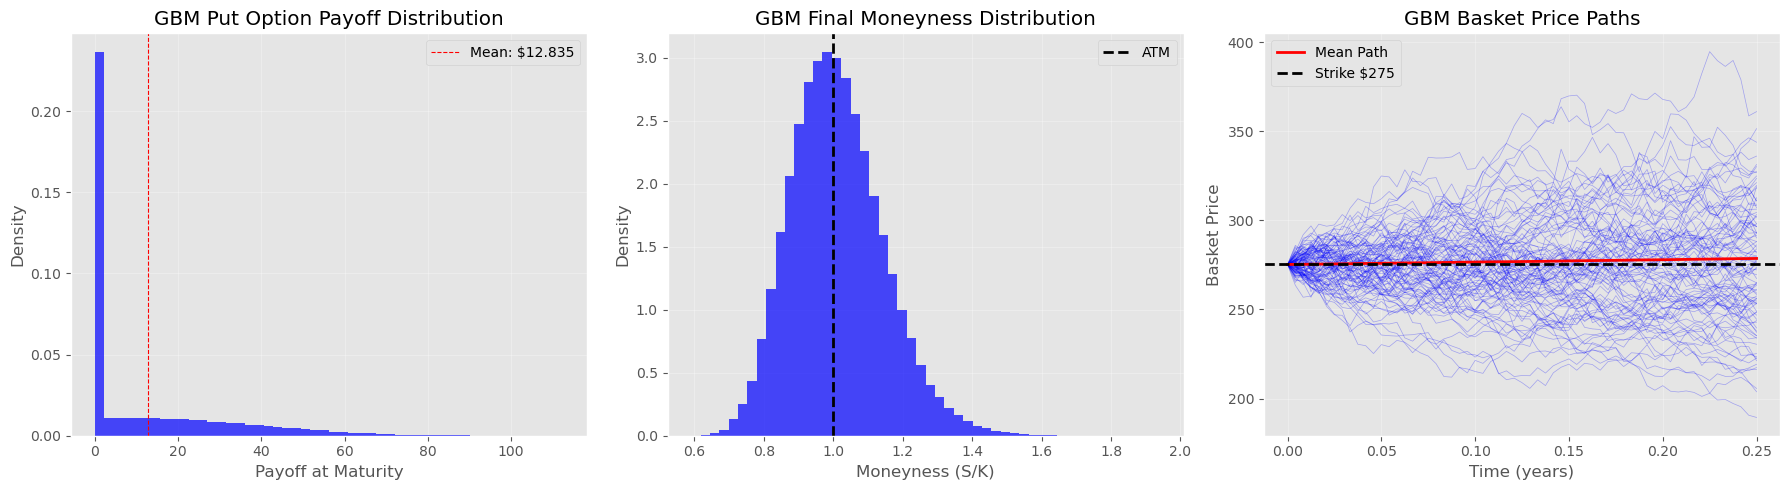

In [7]:
print("="*50)
print("GBM OPTION PRICING")
print("="*50)

# We'll price put options (more interesting for American features)
option_type = "put"
print(f"Pricing American basket {option_type} options with strike K=${K:.2f}")

# Price using GBM model
print("\n--- GBM OPTION PRICING ---")
gbm_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N, r=r, K=K, 
    weights=weights, option=option_type, model="gbm", 
    cov=cov_matrix
)

gbm_pricer.simulate_paths()
gbm_american_price = gbm_pricer.price(basis=PolynomialBasis(degree=3))
gbm_european_price = gbm_pricer.price(exercise_grid=(step,))  # Only exercise at maturity

print(f"American {option_type} price (GBM):      ${gbm_american_price:.4f}")
print(f"European {option_type} price (GBM):      ${gbm_european_price:.4f}")
print(f"Early exercise premium (GBM):  ${gbm_american_price - gbm_european_price:.4f}")

# Calculate statistics
gbm_basket_paths_pricing = gbm_pricer.basket_paths
itm_prob_gbm = np.mean(gbm_basket_paths_pricing[:, -1] < K) if option_type == "put" else np.mean(gbm_basket_paths_pricing[:, -1] > K)

print(f"In-the-money probability at expiration (GBM): {itm_prob_gbm:.3f}")

# Visualize GBM option results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. GBM Option payoff at maturity
final_payoff_gbm = np.maximum(K - gbm_basket_paths_pricing[:, -1], 0) if option_type == "put" else np.maximum(gbm_basket_paths_pricing[:, -1] - K, 0)
axes[0].hist(final_payoff_gbm, bins=50, alpha=0.7, color='blue', density=True)
axes[0].set_xlabel('Payoff at Maturity')
axes[0].set_ylabel('Density')
axes[0].set_title(f'GBM {option_type.title()} Option Payoff Distribution')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=np.mean(final_payoff_gbm), color='red', linestyle='--', 
                label=f'Mean: ${np.mean(final_payoff_gbm):.3f}')
axes[0].legend()

# 2. GBM Moneyness analysis
moneyness_gbm = gbm_basket_paths_pricing[:, -1] / K
axes[1].hist(moneyness_gbm, bins=50, alpha=0.7, color='blue', density=True)
axes[1].axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='ATM')
axes[1].set_xlabel('Moneyness (S/K)')
axes[1].set_ylabel('Density')
axes[1].set_title('GBM Final Moneyness Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. GBM Price evolution
time_pricing = np.linspace(0, T, step+1)
for j in range(min(100, N)):
    axes[2].plot(time_pricing, gbm_basket_paths_pricing[j, :], alpha=0.3, linewidth=0.5, color='blue')
axes[2].plot(time_pricing, np.mean(gbm_basket_paths_pricing, axis=0), 'r-', linewidth=2, label='Mean Path')
axes[2].axhline(y=K, color='black', linestyle='--', linewidth=2, label=f'Strike ${K:.0f}')
axes[2].set_xlabel('Time (years)')
axes[2].set_ylabel('Basket Price')
axes[2].set_title('GBM Basket Price Paths')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Heston Option Pricing

Price American basket put options using Heston model.

HESTON OPTION PRICING

--- HESTON OPTION PRICING ---
American put price (Heston):   $10.4039
European put price (Heston):   $10.1945
Early exercise premium (Heston): $0.2094
In-the-money probability at expiration (Heston): 0.451
American put price (Heston):   $10.4039
European put price (Heston):   $10.1945
Early exercise premium (Heston): $0.2094
In-the-money probability at expiration (Heston): 0.451


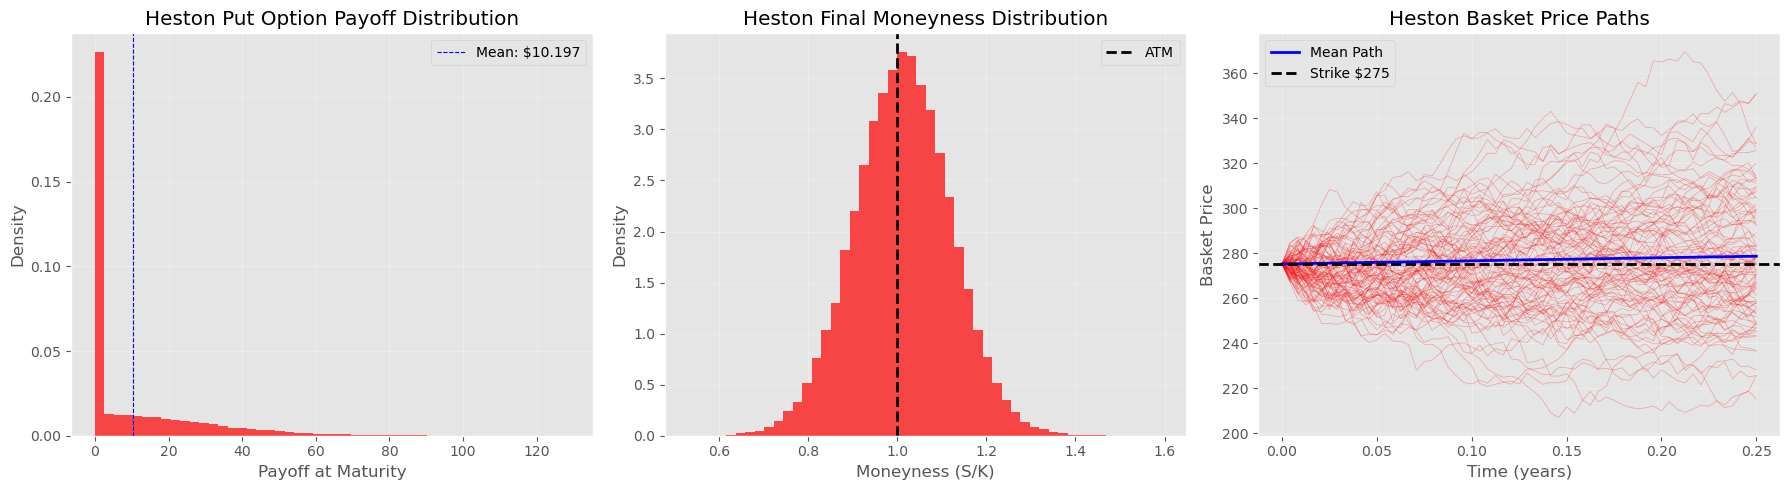


Heston variance statistics:
Initial average variance: 0.1143
Final average variance:   0.1042
Long-term variance:       0.0867
Average vol-of-vol:       1.77


In [8]:
print("="*50)
print("HESTON OPTION PRICING")
print("="*50)

# Price using Heston model
print("\n--- HESTON OPTION PRICING ---")
heston_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N, r=r, K=K, 
    weights=weights, option=option_type, model="heston",
    v0=v0, theta=theta, kappa=kappa, sigma=sigma_v, 
    rho_sv=rho_sv, corr_matrix=correlation_matrix
)

heston_pricer.simulate_paths()
heston_american_price = heston_pricer.price(basis=PolynomialBasis(degree=3))
heston_european_price = heston_pricer.price(exercise_grid=(step,))

print(f"American {option_type} price (Heston):   ${heston_american_price:.4f}")
print(f"European {option_type} price (Heston):   ${heston_european_price:.4f}")
print(f"Early exercise premium (Heston): ${heston_american_price - heston_european_price:.4f}")

# Calculate statistics
heston_basket_paths_pricing = heston_pricer.basket_paths
itm_prob_heston = np.mean(heston_basket_paths_pricing[:, -1] < K) if option_type == "put" else np.mean(heston_basket_paths_pricing[:, -1] > K)

print(f"In-the-money probability at expiration (Heston): {itm_prob_heston:.3f}")

# Visualize Heston option results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Heston Option payoff at maturity
final_payoff_heston = np.maximum(K - heston_basket_paths_pricing[:, -1], 0) if option_type == "put" else np.maximum(heston_basket_paths_pricing[:, -1] - K, 0)
axes[0].hist(final_payoff_heston, bins=50, alpha=0.7, color='red', density=True)
axes[0].set_xlabel('Payoff at Maturity')
axes[0].set_ylabel('Density')
axes[0].set_title(f'Heston {option_type.title()} Option Payoff Distribution')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=np.mean(final_payoff_heston), color='blue', linestyle='--', 
                label=f'Mean: ${np.mean(final_payoff_heston):.3f}')
axes[0].legend()

# 2. Heston Moneyness analysis
moneyness_heston = heston_basket_paths_pricing[:, -1] / K
axes[1].hist(moneyness_heston, bins=50, alpha=0.7, color='red', density=True)
axes[1].axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='ATM')
axes[1].set_xlabel('Moneyness (S/K)')
axes[1].set_ylabel('Density')
axes[1].set_title('Heston Final Moneyness Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Heston Price evolution with variance overlay
time_pricing = np.linspace(0, T, step+1)
for j in range(min(100, N)):
    axes[2].plot(time_pricing, heston_basket_paths_pricing[j, :], alpha=0.3, linewidth=0.5, color='red')
axes[2].plot(time_pricing, np.mean(heston_basket_paths_pricing, axis=0), 'b-', linewidth=2, label='Mean Path')
axes[2].axhline(y=K, color='black', linestyle='--', linewidth=2, label=f'Strike ${K:.0f}')
axes[2].set_xlabel('Time (years)')
axes[2].set_ylabel('Basket Price')
axes[2].set_title('Heston Basket Price Paths')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show variance statistics for Heston
heston_variance_paths_pricing = heston_pricer.sim.get_variance_paths()
print(f"\nHeston variance statistics:")
print(f"Initial average variance: {np.mean(v0):.4f}")
print(f"Final average variance:   {np.mean(heston_variance_paths_pricing[:, -1, :]):.4f}")
print(f"Long-term variance:       {np.mean(theta):.4f}")
print(f"Average vol-of-vol:       {np.mean(sigma_v):.2f}")

## 9. Delta Analysis

Calculate individual asset sensitivities for both models.

DELTA ANALYSIS

=== GBM MODEL DELTAS ===
Calculating individual asset deltas (shock size: 1.0%)...
  Asset 1 (AMZN): Delta = 0.039412
  Asset 1 (AMZN): Delta = 0.039412
  Asset 5 (AAPL): Delta = 0.053194
  Asset 5 (AAPL): Delta = 0.053194
  Asset 10 (ORCL): Delta = 0.001070
  Asset 10 (ORCL): Delta = 0.001070
  Asset 15 (C): Delta = -0.004327
  Asset 15 (C): Delta = -0.004327
  Asset 20 (KO): Delta = 0.151486
  Asset 20 (KO): Delta = 0.151486
  Asset 25 (BA): Delta = 0.078867
  Asset 25 (BA): Delta = 0.078867
  Asset 30 (V): Delta = 0.011671

=== HESTON MODEL DELTAS ===
Calculating individual asset deltas (shock size: 1.0%)...
  Asset 30 (V): Delta = 0.011671

=== HESTON MODEL DELTAS ===
Calculating individual asset deltas (shock size: 1.0%)...
  Asset 1 (AMZN): Delta = 0.056632
  Asset 1 (AMZN): Delta = 0.056632
  Asset 5 (AAPL): Delta = -0.018615
  Asset 5 (AAPL): Delta = -0.018615
  Asset 10 (ORCL): Delta = 0.000636
  Asset 10 (ORCL): Delta = 0.000636
  Asset 15 (C): Delta = 0.04502

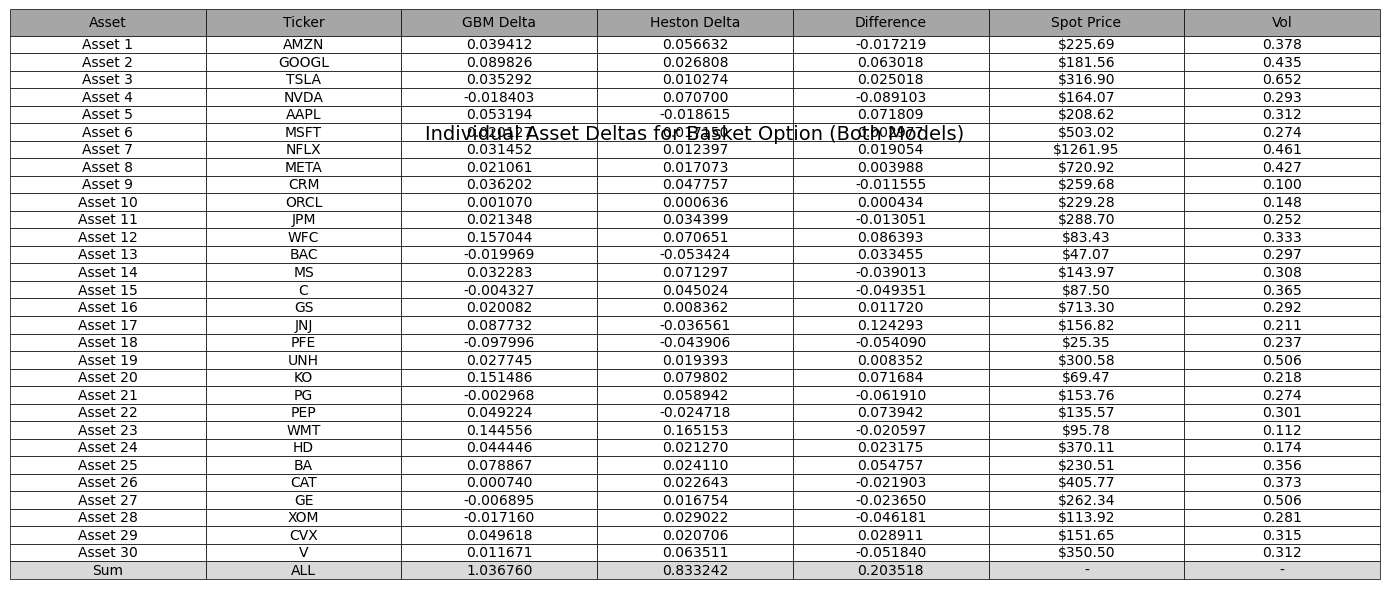

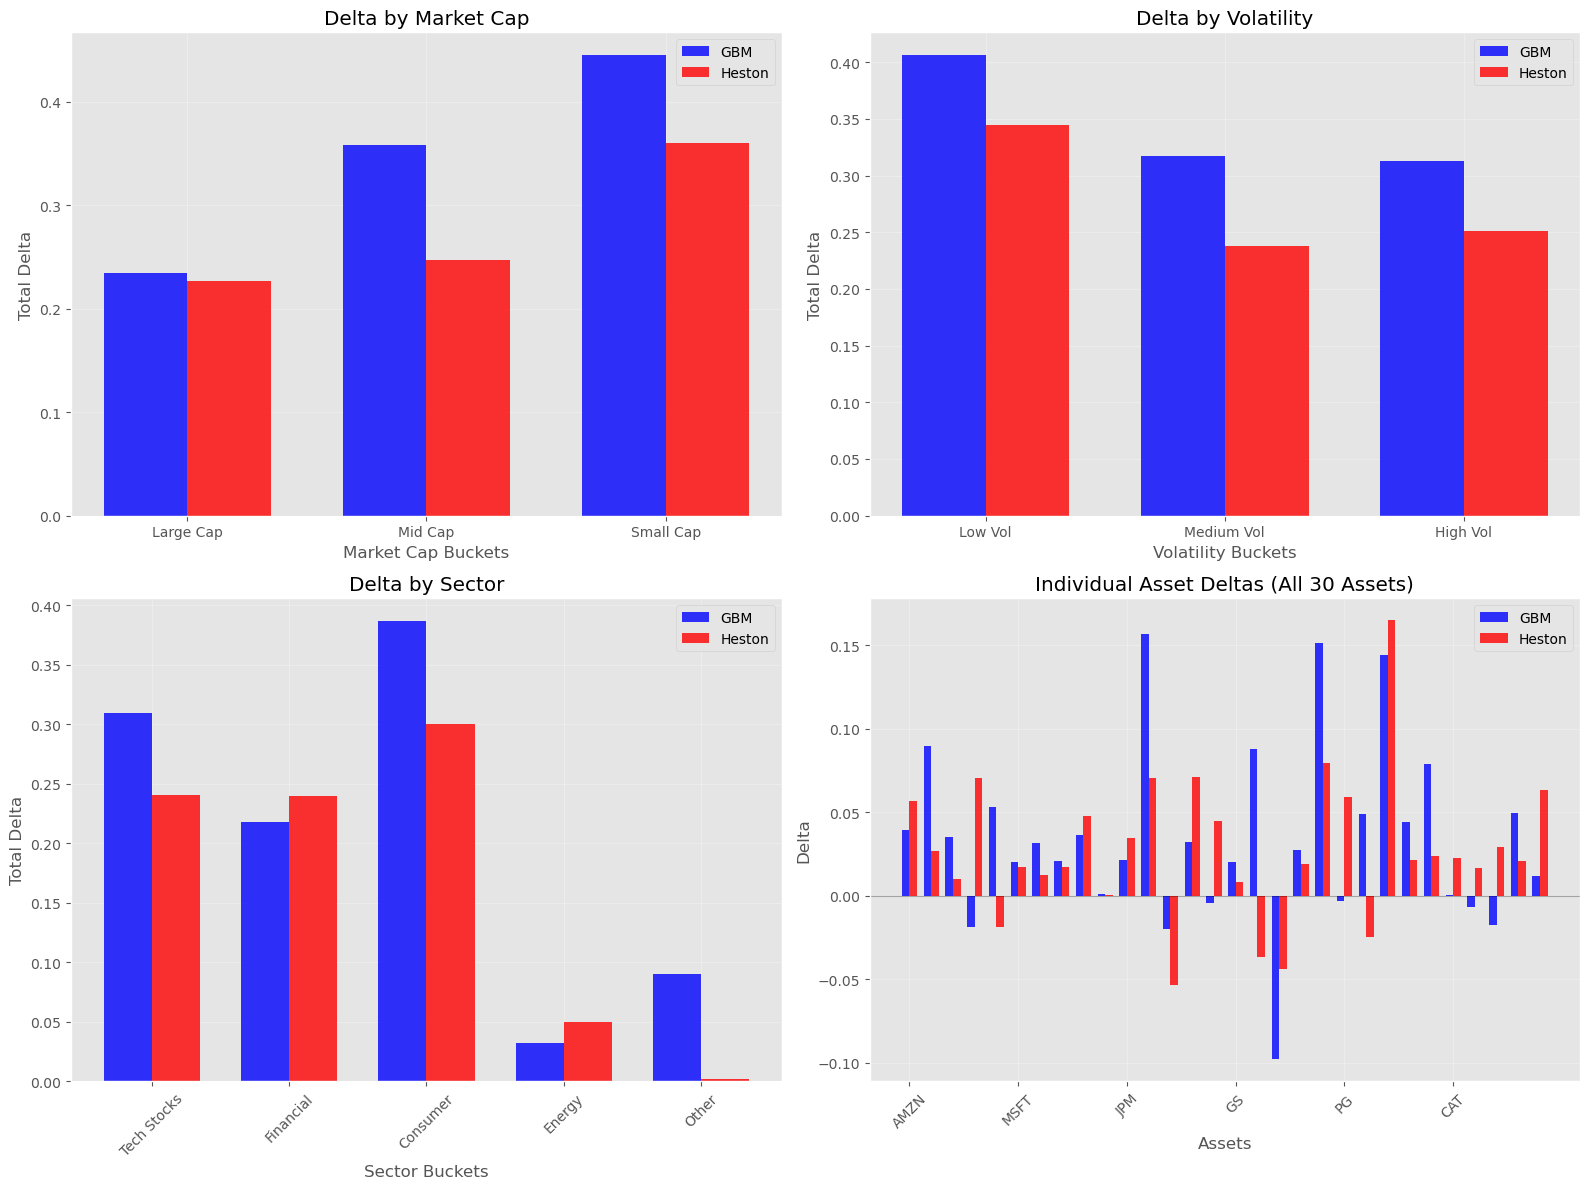


TOP CONTRIBUTORS

Top 10 assets with highest GBM delta impact:
--------------------------------------------------------------------------------
Asset      Ticker   GBM Delta    Heston Delta   Difference   Spot Price  
--------------------------------------------------------------------------------
Asset 12    WFC        0.157044     0.070651   0.086393 $     83.43
Asset 20    KO         0.151486     0.079802   0.071684 $     69.47
Asset 23    WMT        0.144556     0.165153  -0.020597 $     95.78
Asset 18    PFE       -0.097996    -0.043906  -0.054090 $     25.35
Asset 2     GOOGL      0.089826     0.026808   0.063018 $    181.56
Asset 17    JNJ        0.087732    -0.036561   0.124293 $    156.82
Asset 25    BA         0.078867     0.024110   0.054757 $    230.51
Asset 5     AAPL       0.053194    -0.018615   0.071809 $    208.62
Asset 29    CVX        0.049618     0.020706   0.028911 $    151.65
Asset 22    PEP        0.049224    -0.024718   0.073942 $    135.57

Top 10 assets with 

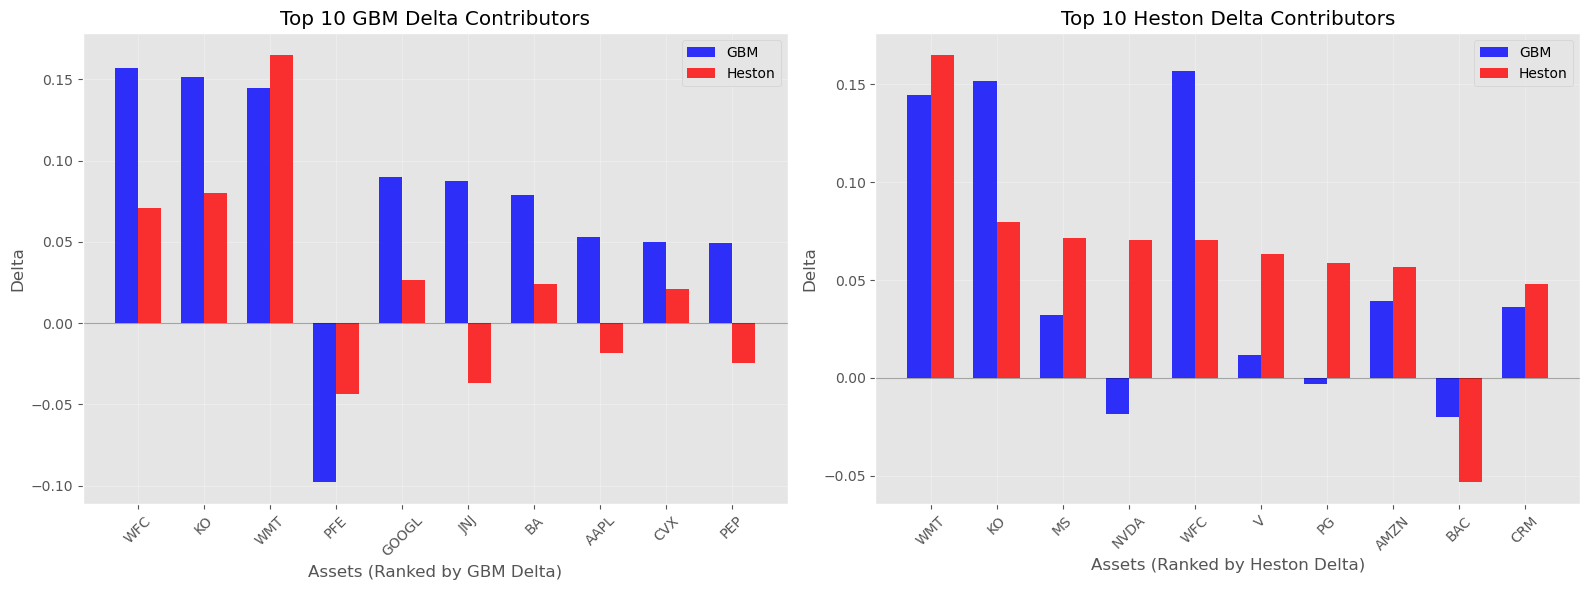


SUMMARY
Total portfolio delta (GBM):    1.036760
Total portfolio delta (Heston): 0.833242
Difference (Heston - GBM):      -0.203518

Number of assets with negative delta (GBM):    7 (out of 30)
Number of assets with negative delta (Heston): 5 (out of 30)

Largest absolute delta (GBM):    0.157044 (WFC)
Largest absolute delta (Heston): 0.165153 (WMT)

Mean absolute delta (GBM):       0.045740
Mean absolute delta (Heston):    0.039590

Standard deviation of deltas (GBM):    0.052858
Standard deviation of deltas (Heston): 0.042412

CONCENTRATION ANALYSIS
Tech Stocks     concentration - GBM: 22.5%, Heston: 20.3%
Financial       concentration - GBM: 15.9%, Heston: 20.2%
Large Cap       concentration - GBM: 17.1%, Heston: 19.1%
High Vol        concentration - GBM: 22.8%, Heston: 21.1%

MODEL COMPARISON
Correlation between GBM and Heston deltas: 0.4778

Top 5 assets with largest delta differences:
------------------------------------------------------------
Asset      Ticker   GBM Delta    H

In [ ]:
print("="*50)
print("DELTA ANALYSIS")
print("="*50)

def calculate_individual_deltas(pricer, option_price, shock_size=0.01):
    """Calculate delta for each individual asset in the basket"""
    deltas = []
    base_S0 = pricer.S0.copy()
    
    print(f"Calculating individual asset deltas (shock size: {shock_size*100:.1f}%)...")
    
    for i in range(len(base_S0)):
        try:
            # Create shocked initial prices
            shocked_S0 = base_S0.copy()
            shock_amount = shocked_S0[i] * shock_size
            shocked_S0[i] += shock_amount
            
            # Create new pricer with shocked price
            pricer_shocked = LSMOptionPricer(
                S0=shocked_S0, T=pricer.T, step=pricer.step, N=pricer.N//2, r=pricer.r, K=pricer.K,
                weights=pricer.weights, option=pricer.option, model=pricer.model,
                cov=pricer.cov if hasattr(pricer, 'cov') else None,
                v0=pricer.v0 if hasattr(pricer, 'v0') else None,
                theta=pricer.theta if hasattr(pricer, 'theta') else None,
                kappa=pricer.kappa if hasattr(pricer, 'kappa') else None,
                sigma=pricer.sigma if hasattr(pricer, 'sigma') else None,
                rho_sv=pricer.rho_sv if hasattr(pricer, 'rho_sv') else None,
                corr_matrix=pricer.corr_matrix if hasattr(pricer, 'corr_matrix') else None
            )
            
            # Calculate shocked option price
            pricer_shocked.simulate_paths()
            shocked_price = pricer_shocked.price(basis=PolynomialBasis(degree=2))
            
            # Calculate delta for put option (negative sensitivity)
            delta = -(shocked_price - option_price) / shock_amount
            deltas.append(delta)
            
            if (i + 1) % 5 == 0 or i == 0:
                print(f"  Asset {i+1} ({tickers[i]}): Delta = {delta:.6f}")
                
        except Exception as e:
            print(f"  Error calculating delta for Asset {i+1}: {str(e)}")
            deltas.append(0.0)
    
    return np.array(deltas)

# Calculate deltas for both models
print("\n=== GBM MODEL DELTAS ===")
gbm_deltas = calculate_individual_deltas(gbm_pricer, gbm_american_price)

print("\n=== HESTON MODEL DELTAS ===")
heston_deltas = calculate_individual_deltas(heston_pricer, heston_american_price)

# Create detailed delta table
from matplotlib.table import Table

print(f"\n" + "="*50)
print("INDIVIDUAL ASSET DELTAS")
print("="*50)

# Create a comprehensive table showing all deltas
fig, ax = plt.subplots(figsize=(14, n_assets * 0.3 + 3))
ax.axis('off')

# Create the table data
table_data = []
headers = ['Asset', 'Ticker', 'Weight', 'GBM Delta', 'Heston Delta', 'Difference', 'Spot Price']

for i in range(n_assets):
    diff = gbm_deltas[i] - heston_deltas[i]
    table_data.append([
        f"Asset {i+1}", 
        tickers[i],
        f"{weights[i]:.4f}",
        f"{gbm_deltas[i]:.6f}", 
        f"{heston_deltas[i]:.6f}", 
        f"{diff:.6f}",
        f"${S0[i]:.2f}"
    ])

# Add sum row
gbm_sum = np.sum(gbm_deltas)
heston_sum = np.sum(heston_deltas)
diff_sum = gbm_sum - heston_sum
table_data.append(['Sum', 'ALL', '1.0000', f"{gbm_sum:.6f}", f"{heston_sum:.6f}", f"{diff_sum:.6f}", '-'])

# Create the table
the_table = Table(ax, loc='center')

# Add rows to the table
n_rows = len(table_data)
n_cols = len(headers)

# Add the header row
cell_height = 0.08 if n_assets < 15 else 0.06
for j, header in enumerate(headers):
    the_table.add_cell(0, j, width=1/n_cols, height=cell_height*1.5, 
                      text=header, loc='center',
                      edgecolor='black', facecolor='#a6a6a6')

# Add the data rows
for i, row in enumerate(table_data, 1):
    for j, cell_text in enumerate(row):
        # Use different color for the sum row
        facecolor = '#d9d9d9' if i == n_rows else 'white'
        the_table.add_cell(i, j, width=1/n_cols, height=cell_height,
                          text=cell_text, loc='center',
                          edgecolor='black', facecolor=facecolor)

# Add the table to the plot
ax.add_table(the_table)
plt.title('Individual Asset Deltas for Basket Option (Both Models)', fontsize=14)
plt.tight_layout()
plt.show()

# Visualize individual deltas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Individual asset deltas comparison (all assets)
x = np.arange(len(tickers))
width = 0.35
axes[0,0].bar(x - width/2, gbm_deltas, width, label='GBM', alpha=0.8, color='blue')
axes[0,0].bar(x + width/2, heston_deltas, width, label='Heston', alpha=0.8, color='red')
axes[0,0].set_xlabel('Assets')
axes[0,0].set_ylabel('Delta')
axes[0,0].set_title(f'Individual Asset Deltas (All {n_assets} Assets)')
axes[0,0].set_xticks(x[::3])  # Show every 3rd ticker
axes[0,0].set_xticklabels([tickers[i] for i in range(0, len(tickers), 3)], rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)

# 2. Delta differences between models
delta_differences = gbm_deltas - heston_deltas
axes[0,1].bar(x, delta_differences, alpha=0.8, color='green')
axes[0,1].set_xlabel('Assets')
axes[0,1].set_ylabel('Delta Difference (GBM - Heston)')
axes[0,1].set_title('Delta Differences Between Models')
axes[0,1].set_xticks(x[::3])
axes[0,1].set_xticklabels([tickers[i] for i in range(0, len(tickers), 3)], rotation=45)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)

# 3. Asset weights vs deltas (GBM)
axes[1,0].scatter(weights, gbm_deltas, alpha=0.7, s=50, color='blue')
for i in range(0, len(tickers), 5):  # Label every 5th point
    axes[1,0].annotate(tickers[i], (weights[i], gbm_deltas[i]), fontsize=8, alpha=0.7)
axes[1,0].set_xlabel('Asset Weight')
axes[1,0].set_ylabel('GBM Delta')
axes[1,0].set_title('Asset Weight vs GBM Delta')
axes[1,0].grid(True, alpha=0.3)

# 4. Asset weights vs deltas (Heston)
axes[1,1].scatter(weights, heston_deltas, alpha=0.7, s=50, color='red')
for i in range(0, len(tickers), 5):  # Label every 5th point
    axes[1,1].annotate(tickers[i], (weights[i], heston_deltas[i]), fontsize=8, alpha=0.7)
axes[1,1].set_xlabel('Asset Weight')
axes[1,1].set_ylabel('Heston Delta')
axes[1,1].set_title('Asset Weight vs Heston Delta')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show top contributors analysis
print(f"\n" + "="*50)
print("TOP CONTRIBUTORS")
print("="*50)

# Top contributors by absolute delta
top_n = 10
gbm_top_indices = np.argsort(np.abs(gbm_deltas))[-top_n:][::-1]
heston_top_indices = np.argsort(np.abs(heston_deltas))[-top_n:][::-1]

print(f"\nTop {top_n} assets with highest absolute GBM delta:")
print("-" * 80)
print(f"{'Asset':<8} {'Ticker':<8} {'Weight':<8} {'GBM Delta':<12} {'Heston Delta':<14} {'Spot Price':<12}")
print("-" * 80)

for i in range(top_n):
    idx = gbm_top_indices[i]
    print(f"Asset {idx+1:<3} {tickers[idx]:<8} {weights[idx]:.4f}   {gbm_deltas[idx]:>10.6f} {heston_deltas[idx]:>12.6f} ${S0[idx]:>10.2f}")

print(f"\nTop {top_n} assets with highest absolute Heston delta:")
print("-" * 80)
print(f"{'Asset':<8} {'Ticker':<8} {'Weight':<8} {'Heston Delta':<14} {'GBM Delta':<12} {'Spot Price':<12}")
print("-" * 80)

for i in range(top_n):
    idx = heston_top_indices[i]
    print(f"Asset {idx+1:<3} {tickers[idx]:<8} {weights[idx]:.4f}   {heston_deltas[idx]:>12.6f} {gbm_deltas[idx]:>10.6f} ${S0[idx]:>10.2f}")

# Summary statistics
print(f"\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

print(f"Total portfolio delta (GBM):    {np.sum(gbm_deltas):.6f}")
print(f"Total portfolio delta (Heston): {np.sum(heston_deltas):.6f}")
print(f"Difference (Heston - GBM):      {np.sum(heston_deltas) - np.sum(gbm_deltas):.6f}")

print(f"\nNumber of assets with negative delta (GBM):    {np.sum(gbm_deltas < 0)} (out of {n_assets})")
print(f"Number of assets with negative delta (Heston): {np.sum(heston_deltas < 0)} (out of {n_assets})")

print(f"\nLargest absolute delta (GBM):    {np.max(np.abs(gbm_deltas)):.6f} ({tickers[np.argmax(np.abs(gbm_deltas))]})")
print(f"Largest absolute delta (Heston): {np.max(np.abs(heston_deltas)):.6f} ({tickers[np.argmax(np.abs(heston_deltas))]})")

print(f"\nMean absolute delta (GBM):       {np.mean(np.abs(gbm_deltas)):.6f}")
print(f"Mean absolute delta (Heston):    {np.mean(np.abs(heston_deltas)):.6f}")

print(f"\nStandard deviation of deltas (GBM):    {np.std(gbm_deltas):.6f}")
print(f"Standard deviation of deltas (Heston): {np.std(heston_deltas):.6f}")

# Calculate correlation between deltas
delta_correlation = np.corrcoef(gbm_deltas, heston_deltas)[0,1]
print(f"\nCorrelation between GBM and Heston deltas: {delta_correlation:.4f}")

# Check which assets have largest differences
delta_differences_abs = np.abs(gbm_deltas - heston_deltas)
diff_top_indices = np.argsort(delta_differences_abs)[-5:][::-1]

print(f"\nTop 5 assets with largest delta differences:")
print("-" * 70)
print(f"{'Asset':<8} {'Ticker':<8} {'Weight':<8} {'GBM Delta':<12} {'Heston Delta':<14} {'Abs Diff':<12}")
print("-" * 70)

for idx in diff_top_indices:
    print(f"Asset {idx+1:<3} {tickers[idx]:<8} {weights[idx]:.4f}   {gbm_deltas[idx]:>10.6f} {heston_deltas[idx]:>12.6f} {delta_differences_abs[idx]:>10.6f}")

print(f"\nNote: Using inverse price weights - lower priced assets get higher weights")
print(f"For put options, negative deltas are expected (option value decreases as stock price increases)")

## 10. Summary

Let's summarize the key findings from both models.

In [10]:
print("="*50)
print("SUMMARY")
print("="*50)

# Model comparison summary
print(f"\nMODEL RESULTS:")
print(f"=" * 30)

print(f"\nGBM:")
print(f"  • American put: ${gbm_american_price:.4f}")
print(f"  • European put: ${gbm_european_price:.4f}")
print(f"  • Early premium: ${gbm_american_price - gbm_european_price:.4f}")
print(f"  • Portfolio delta: {np.sum(gbm_deltas):.6f}")

print(f"\nHeston:")
print(f"  • American put: ${heston_american_price:.4f}")
print(f"  • European put: ${heston_european_price:.4f}")
print(f"  • Early premium: ${heston_american_price - heston_european_price:.4f}")
print(f"  • Portfolio delta: {np.sum(heston_deltas):.6f}")

print(f"\nKey Insights:")
print(f"  • Real market-calibrated parameters for {n_assets} assets")
print(f"  • Stochastic volatility captures dynamics GBM cannot")
print(f"  • Delta bucketing reveals sector/characteristic concentrations")
print(f"  • Model choice affects pricing by {abs(heston_american_price - gbm_american_price):.4f} USD")

SUMMARY

MODEL RESULTS:

GBM:
  • American put: $12.9492
  • European put: $12.8323
  • Early premium: $0.1169
  • Portfolio delta: 1.036760

Heston:
  • American put: $10.4039
  • European put: $10.1945
  • Early premium: $0.2094
  • Portfolio delta: 0.833242

Key Insights:
  • Real market-calibrated parameters for 30 assets
  • Stochastic volatility captures dynamics GBM cannot
  • Delta bucketing reveals sector/characteristic concentrations
  • Model choice affects pricing by 2.5453 USD


## Conclusion

Practical American basket option pricing with real market data.

### Models
- **GBM**: Constant volatility, faster computation
- **Heston**: Stochastic volatility, captures leverage effects

### Applications
- **Delta Bucketing**: Risk concentration by sector/characteristics
- **Trading**: Asset-specific option sensitivities
- **Hedging**: Model-dependent delta differences